In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit
import matplotlib.pyplot as plt
%matplotlib inline
NB_SEED = 123123

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

In [35]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [36]:
tr = setindexdatetime(pd.read_csv('valids/v_ready_iqr_tr.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')

In [37]:
tr.index.freq = '15T'

In [38]:
ts = resample(ts)

/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:73: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:76: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [39]:
tr_Target = tr.Target.copy()

In [40]:
######## ADDING TIME RELATED FEATURES TO DATA #########
#Weekday, Hour, Month
tr['Date'] = tr.index.values
tr['Weekday'] = tr.Date.apply(lambda x: x.weekday())
tr['Hour'] = tr.Date.apply(lambda x: x.hour)
tr['Month'] = tr.Date.apply(lambda x: x.month)
tr['DayCnt'] = tr.Date.apply(lambda x: x.toordinal())

ts['Date'] = ts.index.values
ts['Weekday'] = ts.Date.apply(lambda x: x.weekday())
ts['Hour'] = ts.Date.apply(lambda x: x.hour)
ts['Month'] = ts.Date.apply(lambda x: x.month)
ts['DayCnt'] = ts.Date.apply(lambda x: x.toordinal())

tr = pd.get_dummies(tr, columns=["Month","Hour","Weekday"])
ts = pd.get_dummies(ts, columns=["Month","Hour","Weekday"])
tr.drop('Date',1,inplace=True)
ts.drop('Date',1,inplace=True)

In [41]:
from sklearn.preprocessing import MinMaxScaler
trsc = MinMaxScaler()
tssc = MinMaxScaler()
tr_nf = tr.loc[:,tr.dtypes!="float64"]
ts_nf = ts.loc[:,ts.dtypes!="float64"]
tr_cont = tr.loc[:,tr.dtypes=="float64"].drop('Target',1)
tr_cont_names = tr_cont.columns.values
tr_cont_idx = tr_cont.index
ts_cont = ts.loc[:,ts.dtypes=="float64"]
ts_cont_names = ts_cont.columns.values
ts_cont_idx = ts_cont.index
tr_cont = trsc.fit_transform(tr_cont)
ts_cont = tssc.fit_transform(ts_cont)
tr_cont = pd.DataFrame(tr_cont)
ts_cont = pd.DataFrame(ts_cont)
tr_cont.columns = tr_cont_names
ts_cont.columns = ts_cont_names
tr_cont.index = tr_cont_idx
ts_cont.index = ts_cont_idx

tr = tr_nf.join(tr_cont).join(tr_Target)
ts = ts_nf.join(ts_cont)

In [42]:
x_tr, x_ts, y_tr, y_ts = TSSplit(tr.drop('Target',1),tr.Target, test_size=0.30)

In [43]:
from sklearn.linear_model import LinearRegression, ElasticNet, HuberRegressor, Lasso, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [44]:
rf = RandomForestRegressor(n_estimators=200,n_jobs=-1,random_state=NB_SEED)
ada = AdaBoostRegressor(random_state=NB_SEED)
ext = ExtraTreesRegressor(random_state=NB_SEED)
lr = LinearRegression(n_jobs=-1)
enet = ElasticNet(random_state=NB_SEED,l1_ratio=0.2)
hbr = HuberRegressor()
rdg = Ridge(random_state=NB_SEED)
svr_g = SVR(kernel='rbf')
svr_l = SVR(kernel='linear')
xgb_t = XGBRegressor(n_jobs=-1,random_state=NB_SEED,reg_lambda=0.3)
xgb_l = XGBRegressor(booster='gblinear', n_jobs=-1, random_state=NB_SEED, reg_lambda=0.3)
meta_lasso = Lasso(random_state=NB_SEED)
ml_largeiter = Lasso(max_iter=2000, random_state=NB_SEED)
meta_enet = ElasticNet(random_state=NB_SEED, l1_ratio=0.8)

In [45]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [46]:
from mlxtend.regressor import StackingCVRegressor

In [50]:
stacked = StackingCVRegressor(regressors=(ada,rf,ext,lr,rdg,enet,hbr,xgb_t,xgb_l,svr_g),
                             meta_regressor=meta_lasso,
                             cv=tscv,
                             use_features_in_secondary=True)

In [51]:
stacked.fit(x_tr.values,y_tr.values)

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123123,
   selection='cyclic', tol=0.0001, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_i..., epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [52]:
y_pred_tr = stacked.predict(x_tr.values)
y_pred_val = stacked.predict(x_ts.values)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [54]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [55]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 20.760423663172812 test: 64.35406287571742
RMSE train: 4.5563607915937485 test: 8.02209840850369
MAE train: 3.2138000593917364 test: 6.595264708348101
R2 train: 0.23184664417800727 test: -0.8038854773936603


In [56]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

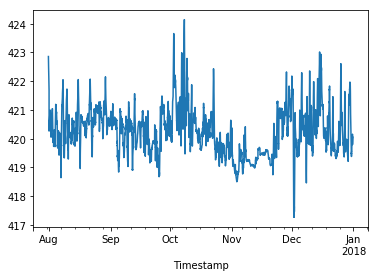

In [57]:
y_pred.plot()

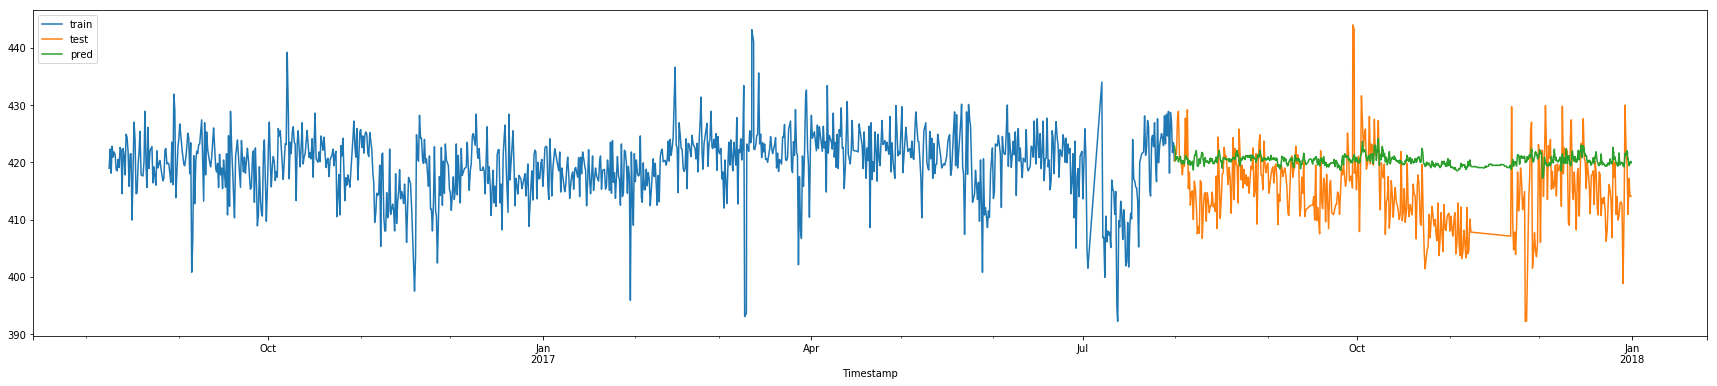

In [58]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [59]:
stacked_M1 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet,svr_g),
                             meta_regressor=meta_lasso,
                             cv=tscv,
                             use_features_in_secondary=True)

In [60]:
stacked_M1.fit(x_tr.values,y_tr.values)

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123123,
   selection='cyclic', tol=0.0001, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu..., epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [61]:
y_pred_tr = stacked_M1.predict(x_tr.values)
y_pred_val = stacked_M1.predict(x_ts.values)

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [63]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [64]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 20.800520636906022 test: 63.02226892681153
RMSE train: 4.560758778636075 test: 7.938656619782186
MAE train: 3.2230686868289533 test: 6.4858528615336315
R2 train: 0.2303630220019286 test: -0.7665544425536117


In [65]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

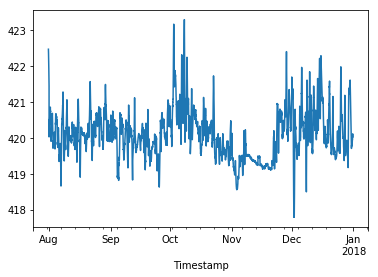

In [66]:
y_pred.plot()

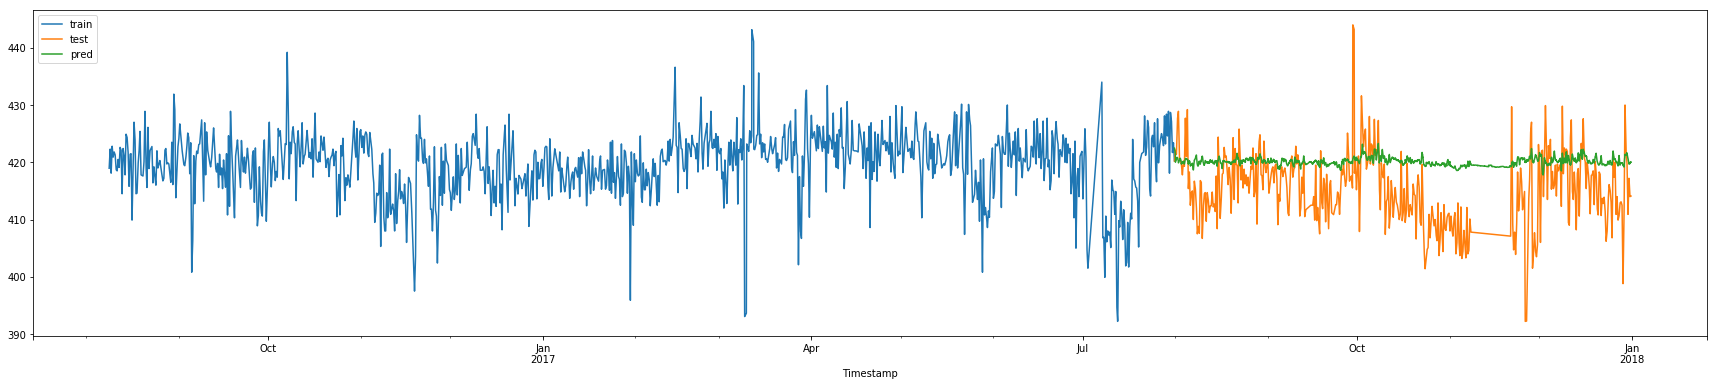

In [67]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [68]:
stacked_M2 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet),
                             meta_regressor=meta_lasso,
                             cv=tscv,
                             use_features_in_secondary=True)

In [69]:
stacked_M2.fit(x_tr.values,y_tr.values)

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123123,
   selection='cyclic', tol=0.0001, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...recompute=False,
      random_state=123123, selection='cyclic', tol=0.0001,
      warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [70]:
y_pred_tr = stacked_M2.predict(x_tr.values)
y_pred_val = stacked_M2.predict(x_ts.values)

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [72]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [73]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 20.800521011640566 test: 63.02226874179573
RMSE train: 4.5607588197185525 test: 7.938656608129346
MAE train: 3.223068709107313 test: 6.485852846104103
R2 train: 0.2303630081364314 test: -0.7665544373675006


In [74]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

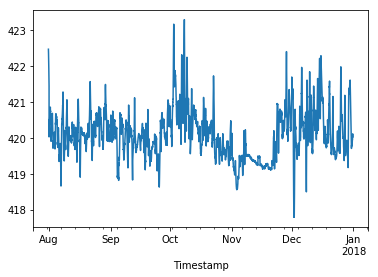

In [75]:
y_pred.plot()

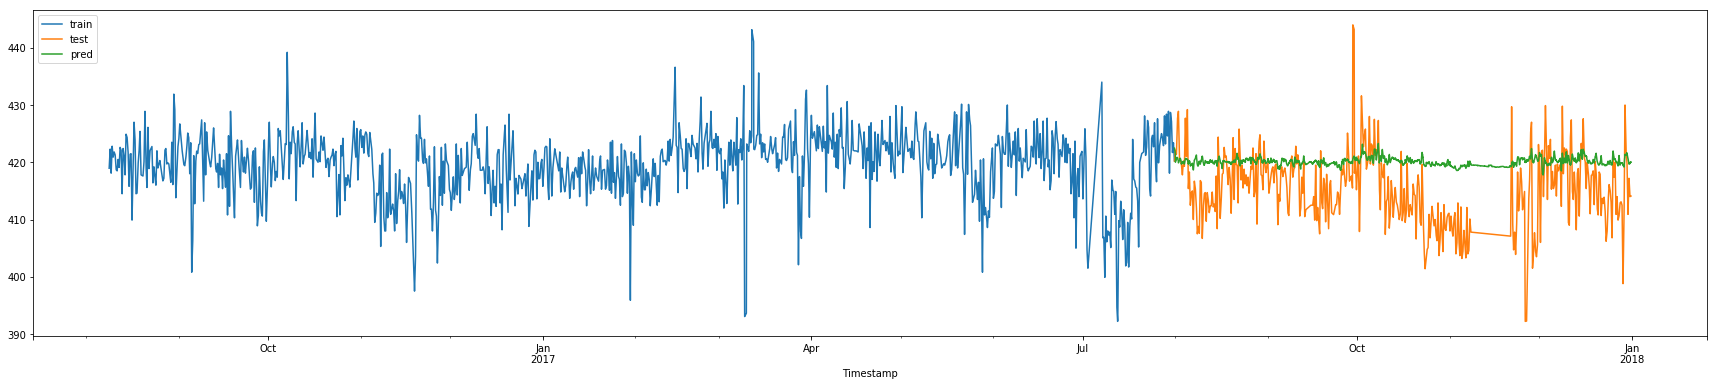

In [76]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [77]:
stacked_M3 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet,svr_g),
                             meta_regressor=meta_lasso,
                             cv=tscv,
                             use_features_in_secondary=False)

In [78]:
stacked_M3.fit(x_tr.values,y_tr.values)

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123123,
   selection='cyclic', tol=0.0001, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu..., epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=False)

In [79]:
y_pred_tr = stacked_M3.predict(x_tr.values)
y_pred_val = stacked_M3.predict(x_ts.values)

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [81]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [82]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 21.16333306166338 test: 48.08967551511418
RMSE train: 4.600362275045671 test: 6.9346719832385855
MAE train: 3.284902441789629 test: 5.5378010185489615
R2 train: 0.21693865330247575 test: -0.3479843136216425


In [83]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

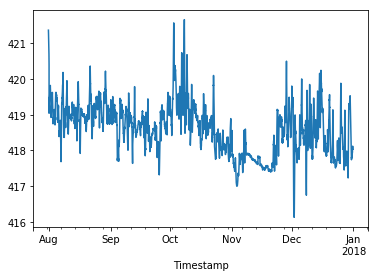

In [84]:
y_pred.plot()

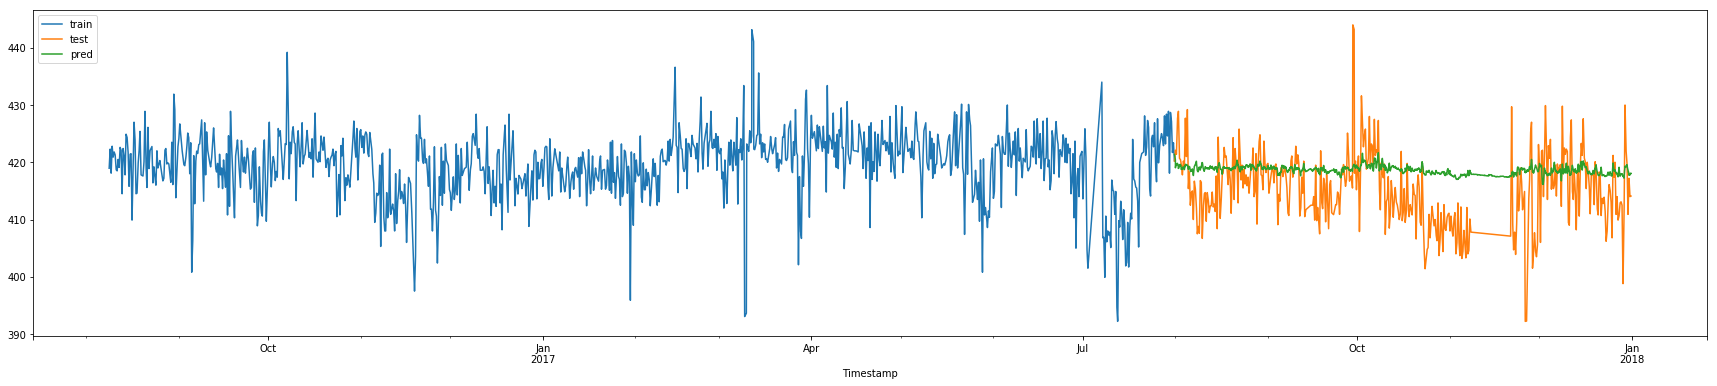

In [85]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [86]:
stacked_M4 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet),
                             meta_regressor=meta_lasso,
                             cv=tscv,
                             use_features_in_secondary=False)

In [87]:
stacked_M4.fit(x_tr.values,y_tr.values)

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123123,
   selection='cyclic', tol=0.0001, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...recompute=False,
      random_state=123123, selection='cyclic', tol=0.0001,
      warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=False)

In [88]:
y_pred_tr = stacked_M4.predict(x_tr.values)
y_pred_val = stacked_M4.predict(x_ts.values)

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [90]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [91]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 21.163333145410267 test: 48.089675623596285
RMSE train: 4.600362284147876 test: 6.934671991060305
MAE train: 3.284902446804007 test: 5.537801025689035
R2 train: 0.21693865020376957 test: -0.3479843166624652


In [92]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

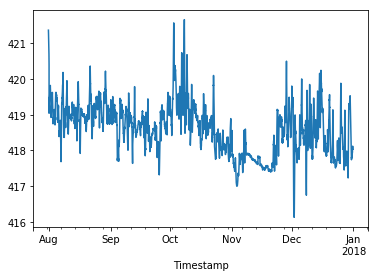

In [93]:
y_pred.plot()

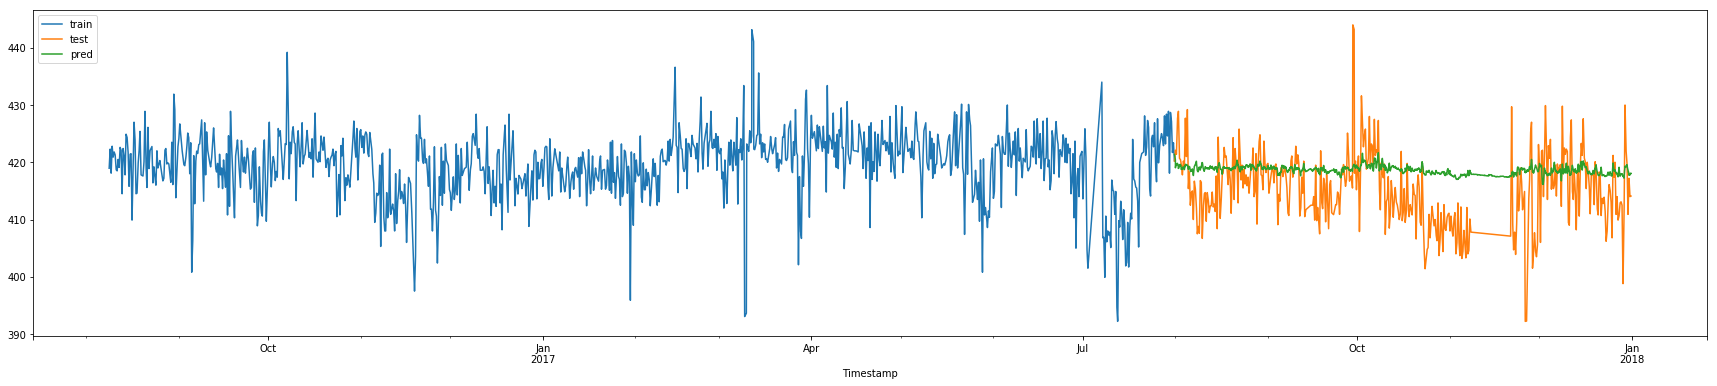

In [94]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [ ]:
stacked_M1_enet = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet,svr_g),
                             meta_regressor=meta_enet,
                             cv=tscv,
                             use_features_in_secondary=True)

In [ ]:
stacked_M1_enet.fit(x_tr.values,y_tr.values)

In [ ]:
y_pred_tr = stacked_M1_enet.predict(x_tr.values)
y_pred_val = stacked_M1_enet.predict(x_ts.values)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [ ]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [ ]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

In [ ]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

In [ ]:
y_pred.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [ ]:
stacked_M1_large = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet,svr_g),
                             meta_regressor=ml_largeiter,
                             cv=tscv,
                             use_features_in_secondary=True)

In [ ]:
stacked_M1_large.fit(x_tr.values,y_tr.values)

In [ ]:
y_pred_tr = stacked_M1_large.predict(x_tr.values)
y_pred_val = stacked_M1_large.predict(x_ts.values)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [ ]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [ ]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

In [ ]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

In [ ]:
y_pred.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')